# Experimental resuls

In [1]:
import torch
from torch import nn
import torch.utils
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import random
import os
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## I. Confusion matrix

In [3]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
from models.HSNet import HSNet_model

In [4]:
class_names = ['Unkown', 'Blur', 'Foam-Fluid', 'Dark', 'Hau hong', 'Thuc quan', 'Tam vi', 'Than vi',
                'Phinh vi', 'Hang vi', 'Bo cong lon','Bo cong nho', 'Hanh ta trang', 'Ta trang']

class_names_rm = ['Hau hong', 'Thuc quan', 'Tam vi', 'Than vi',
                'Phinh vi', 'Hang vi', 'Bo cong lon','Bo cong nho', 'Hanh ta trang', 'Ta trang', 'Unkown']
class_names_1 = ["Non-informative", "Informative"]

In [17]:
path_model = './weights/HSNet_make_pre_Adam_Focal.pt'
model = HSNet_model(pretrained=False).to(device)
model.load_state_dict(torch.load(path_model, map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (

In [18]:
def predict(model, test_dir, batch_size=1):
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []
    with torch.no_grad():
        count = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            _, outputs = model(images)
            # preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1) #mobilenet, efficientnet
            outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1).item()
            if outputs in  range(0, 4):
                outputs  = 10
            else:
                outputs = outputs-4
            all_preds.extend([outputs])
            all_targets.extend(labels.cpu().numpy())
            count += 1
    confusion_mat = confusion_matrix(all_targets, all_preds)
    return confusion_mat

In [19]:
cm = predict(model, r'D:\Lab-Tracks\Gastrointestinal\Evaluate\test_data_2', batch_size=1)

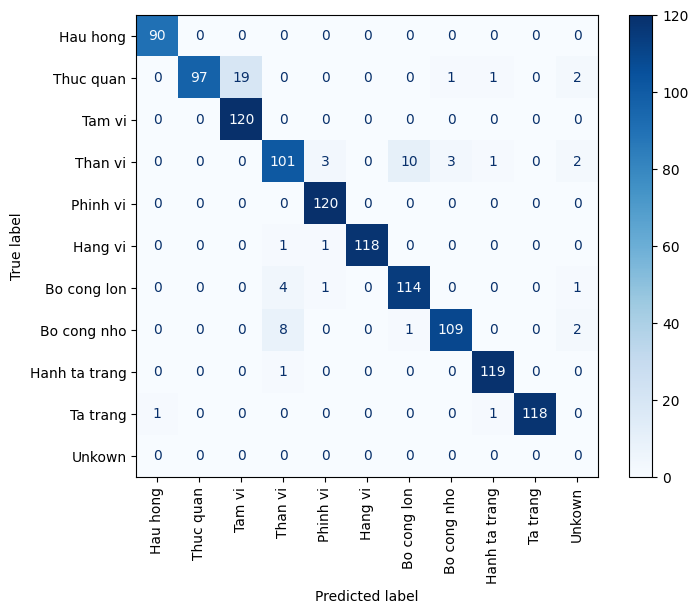

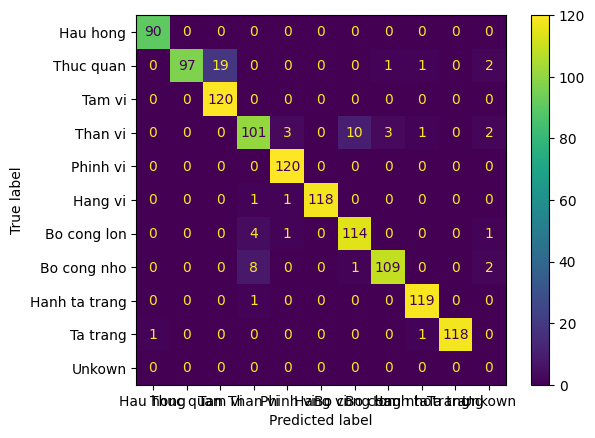

In [20]:
cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=class_names_rm)
fig, ax = plt.subplots(figsize=(8,6), )
cm_display.plot(ax = ax, cmap='Blues')

ax.set_xticks(np.arange(len(class_names_rm)))
ax.set_xticklabels(class_names_rm, rotation=90, ha="center")
# ax.set_yticklabels(class_names, rotation=90, ha="right")
cm_display.plot()

In [21]:
precision = []
recall = []
f1_score = []

for i in range(10):  # 10 là số lớp trong confusion matrix của bạn
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP
    
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score_i = 2 * (precision_i * recall_i) / (precision_i + recall_i) if (precision_i + recall_i) != 0 else 0
    
    precision.append(precision_i)
    recall.append(recall_i)
    f1_score.append(f1_score_i)
precision = [round(num, 4) for num in precision]
recall = [round(num, 4) for num in recall]
f1_score = [round(num, 4) for num in f1_score]
# Tính toán precision trung bình, recall trung bình và F1-score trung bình
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)
for i in range(10):
    print(f" [{class_names_rm[i]}] \n Precision {precision[i]*100}% | Recall {recall[i]*100}%  | F1-score {f1_score[i]*100}%")
print("Everage:")  
print("Everage Precision", avg_precision)
print("Everage Recall:", avg_recall)
print("Everage F1-score:", avg_f1_score)

 [Hau hong] 
 Precision 98.9% | Recall 100.0%  | F1-score 99.45%
 [Thuc quan] 
 Precision 100.0% | Recall 80.83%  | F1-score 89.4%
 [Tam vi] 
 Precision 86.33% | Recall 100.0%  | F1-score 92.66%
 [Than vi] 
 Precision 87.83% | Recall 84.17%  | F1-score 85.96000000000001%
 [Phinh vi] 
 Precision 96.0% | Recall 100.0%  | F1-score 97.96000000000001%
 [Hang vi] 
 Precision 100.0% | Recall 98.33%  | F1-score 99.16%
 [Bo cong lon] 
 Precision 91.2% | Recall 95.0%  | F1-score 93.06%
 [Bo cong nho] 
 Precision 96.46000000000001% | Recall 90.83%  | F1-score 93.56%
 [Hanh ta trang] 
 Precision 97.54% | Recall 99.17%  | F1-score 98.35000000000001%
 [Ta trang] 
 Precision 100.0% | Recall 98.33%  | F1-score 99.16%
Everage:
Everage Precision 0.95426
Everage Recall: 0.94666
Everage F1-score: 0.94872


In [18]:
class HierarchicalClassificationDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.img_paths = self.get_img_paths()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_img_paths(self):
        img_paths = []
        for root, dirs, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    img_paths.append(os.path.join(root, file))
        return img_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        level1_label = int(os.path.basename(os.path.dirname(img_path)))
        level2_label = int(os.path.basename(os.path.dirname(os.path.dirname(img_path))))

        return image, level2_label, level1_label

test_loader = HierarchicalClassificationDataset(r'D:\Lab-Tracks\Gastrointestinal\Evaluate\test_data_hier')

In [19]:
def predict(model, test_loader, batch_size=1, device=device):
    test_loader = DataLoader(test_loader, batch_size=batch_size, shuffle=False)
    # model.eval()
    # model.to(device)

    all_preds2 = []
    all_preds1 = []
    all_targets2 = []
    all_targets1 = []
    with torch.no_grad():
        for images, labels1, labels2 in test_loader:
            # Send data to target device
            images, labels1, labels2 = images.to(device), labels1.to(device), labels2.to(device)
            outputs1, outputs2 = model(images)
            preds1 = torch.argmax(torch.softmax(outputs1, dim=1), dim=1) #mobilenet, efficientnet
            preds2 = torch.argmax(torch.softmax(outputs2, dim=1), dim=1) #mobilenet, efficientnet
            # _, preds2 = outputs2.max(1) #resnet\
            # _, preds1 = outputs1.max(1)
            print(preds1, preds2)
            all_preds2.extend(preds2.cpu().numpy())
            all_targets2.extend(labels2.cpu().numpy())

            all_preds1.extend(preds1.cpu().numpy())
            all_targets1.extend(labels1.cpu().numpy())
    confusion_mat_1 = confusion_matrix(all_targets1, all_preds1)
    confusion_mat_2 = confusion_matrix(all_targets2, all_preds2)

    return confusion_mat_1, confusion_mat_2

In [ ]:
cm1, cm2 = predict(model=model, test_loader=test_loader, batch_size=1)

In [78]:
true_predict_labels = 0
all_labels = 0
for i in range (len(cm2)):
    for j in range (len(cm2)):
        all_labels += cm2[i][j]
        if i == j:
            true_predict_labels += cm2[i][j]


In [79]:
accuracy_1  = (true_predict_labels/all_labels)*100
accuracy_1


91.65120593692022

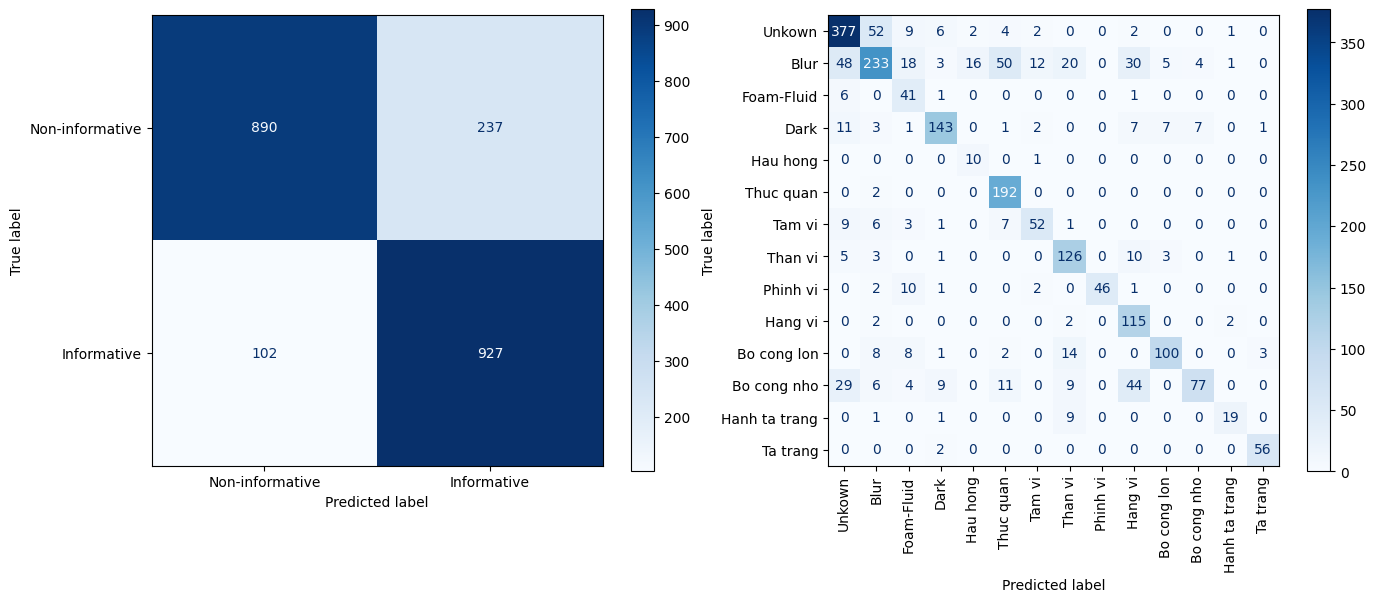

In [10]:
cm_display_1 = metrics.ConfusionMatrixDisplay(cm1, display_labels=class_names_1)
cm_display_2 = metrics.ConfusionMatrixDisplay(cm2, display_labels=class_names)
fig, ax = plt.subplots(1,2, figsize=(16,6))
cm_display_1.plot(ax=ax[0], cmap='Blues')
ax[0].set_xticks(np.arange(len(class_names_1)))
ax[0].set_xticklabels(class_names_1, rotation=0, ha="center")
cm_display_2.plot(ax=ax[1], cmap='Blues')
ax[1].set_xticks(np.arange(len(class_names)))
ax[1].set_xticklabels(class_names, rotation=90, ha="center")

plt.show()
# ax.set_yticklabels(class_names, rotation=90, ha="right")
# cm_display.plot()

In [21]:
cm2_rm = cm2[4:, 4:]

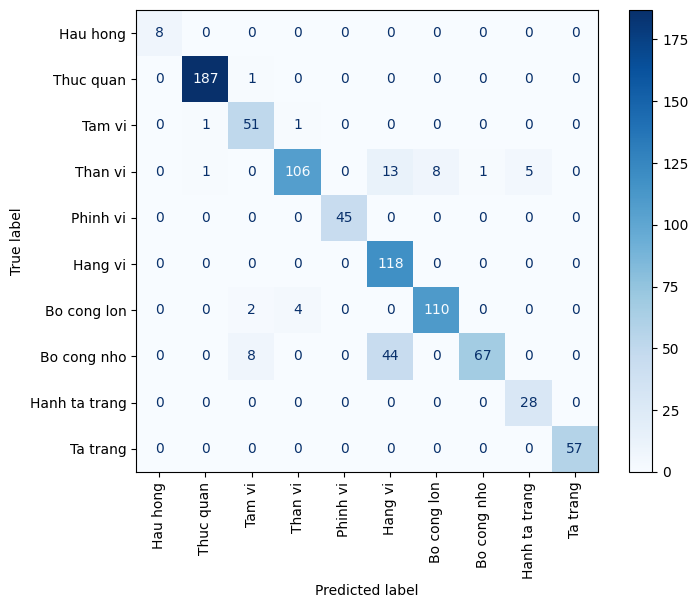

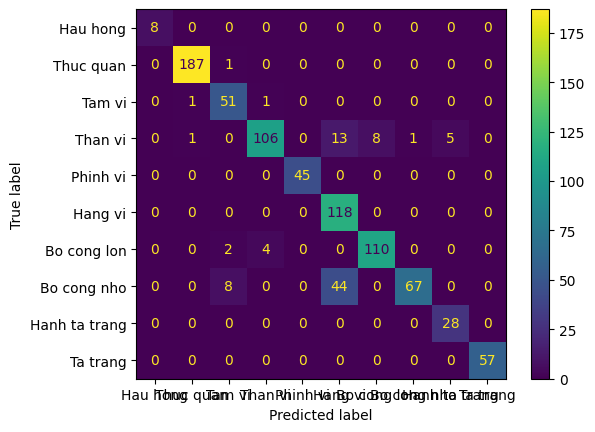

In [24]:
cm_display = metrics.ConfusionMatrixDisplay(cm2_rm, display_labels=class_names_rm)
fig, ax = plt.subplots(figsize=(8,6), )
cm_display.plot(ax = ax, cmap='Blues')

ax.set_xticks(np.arange(len(class_names_rm)))
ax.set_xticklabels(class_names_rm, rotation=90, ha="center")
# ax.set_yticklabels(class_names, rotation=90, ha="right")
cm_display.plot()
